# Import libraries

Use conda env with tensorflow-gpu and keras

In [8]:
# import the necessary packages
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import numpy as np
import geojson
import dask
import os

import tensorflow as tf

from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras import backend as K

from keras.applications.vgg16 import VGG16
from keras.models import Input, Model
from keras.layers import Add, Conv2D, Conv2DTranspose

import cv2
import glob
import json
import numpy as np
import rasterio

from datetime import datetime
from functools import partial
from shapely.geometry import box, mapping
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from skimage import filters

# Instantiating an Interface object automatically logs you in to the GBDX platform
from gbdxtools.task import env
from gbdxtools import CatalogImage
from gbdxtools import Interface
gbdx = Interface()

# Get prebuild training dataset

In [42]:
path = '../../TreeTect/data/trainings_data_waterbodies/data_non_acomp_all_polygons_2020-03-26 12:37:01.698516.csv'


nr_search = path.split('/')[-1].split('_')[4]

nr_search


# Reading the raw data into a Pandas DataFrame

import pandas as pd

data_raw = pd.read_csv(path).drop('Unnamed: 0', axis = 1).drop(['x','y'], axis= 1)

# First we rename the columns of our dataset 

# Bands
# coastal = data[0]
# blue = data[1]
# green = data[2]
# yellow = data[3]
# red = data[4]
# red_edge = data[5]
# nir1 = data[6]
# nir2 = data[7]

    # select variables
property_names = ['cloudCover',
                 'multiResolution',
                 'targetAzimuth',
                 # 'timestamp',
                 'sunAzimuth',
                 'offNadirAngle',
                 # 'platformName',
                 'sunElevation',
                 # 'scanDirection',
                 'panResolution']

data_raw.columns = ['coastal','blue','green','yellow','red','red_edge','nir1','nir2',] + property_names  + ['label']

# Here we will calculate the indices with the band data we already have

data_raw['ndvi'] = (data_raw.nir1 - data_raw.red)/(data_raw.nir1 + data_raw.red)
data_raw['ndwi'] = (data_raw.green - data_raw.nir1)/(data_raw.green + data_raw.nir1)

data_raw['wwi'] = (data_raw.coastal-data_raw.nir2)/(data_raw.coastal+data_raw.nir2+10e-5)

data_clean = data_raw


all_variables = ['coastal','blue','green','yellow','red','red_edge','nir1','nir2',] + property_names + ['ndvi','ndwi', 'wwi']

i = 0 
for variable in all_variables:
    print(i, variable)
    i = i + 1
    
variable_selection = range(17)

all_variables = [all_variables[i] for i in variable_selection]

data = data_clean[all_variables].values

# Normalize training data to between 0 and 1
try:
    min_data =  np.nanmin(data)
    max_data = np.nanmax(data)
    data = (data - min_data) / (max_data - min_data)
except Exception as e:
    print(e)

0 coastal
1 blue
2 green
3 yellow
4 red
5 red_edge
6 nir1
7 nir2
8 cloudCover
9 multiResolution
10 targetAzimuth
11 sunAzimuth
12 offNadirAngle
13 sunElevation
14 panResolution
15 ndvi
16 ndwi
17 wwi


In [43]:
# check data 
data_clean

,coastal,blue,green,yellow,red,red_edge,nir1,nir2,cloudCover,multiResolution,targetAzimuth,sunAzimuth,offNadirAngle,sunElevation,panResolution,label,ndvi,ndwi,wwi
0,1157.0,996.0,867.0,680.0,606.0,355.0,320.0,195.0,4,1.990745,353.378480,42.406155,16.204758,53.59690,0.499102,water,-0.308855,0.460826,0.711538
1,1428.0,1253.0,1064.0,846.0,732.0,445.0,371.0,239.0,4,1.990745,353.378480,42.406155,16.204758,53.59690,0.499102,water,-0.327289,0.482927,0.713257
2,1223.0,1056.0,904.0,688.0,597.0,368.0,321.0,190.0,4,1.990745,353.378480,42.406155,16.204758,53.59690,0.499102,water,-0.300654,0.475918,0.731069
3,1149.0,985.0,854.0,654.0,563.0,346.0,300.0,178.0,4,1.990745,353.378480,42.406155,16.204758,53.59690,0.499102,water,-0.304751,0.480069,0.731726
4,1263.0,1042.0,884.0,686.0,581.0,409.0,331.0,198.0,4,1.990745,353.378480,42.406155,16.204758,53.59690,0.499102,water,-0.274123,0.455144,0.728953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306822,1731.0,1464.0,1225.0,984.0,883.0,1163.0,1682.0,1228.0,36,2.158924,50.913406,114.023445,23.307102,64.75944,0.541851,non_water,0.311501,-0.157207,0.169990
306823,1686.0,1427.0,1146.0,914.0,834.0,938.0,1328.0,954.0,36,2.158924,50.913406,114.023445,23.307102,64.75944,0.541851,non_water,0.228492,-0.073565,0.277273
306824,1684.0,1431.0,1183.0,948.0,854.0,1084.0,1648.0,1198.0,36,2.158924,50.913406,114.023445,23.307102,64.75944,0.541851,non_water,0.317346,-0.164253,0.168633
306825,1681.0,1428.0,1161.0,932.0,844.0,1024.0,1502.0,1084.0,36,2.158924,50.913406,114.023445,23.307102,64.75944,0.541851,non_water,0.280477,-0.128051,0.215913


In [44]:
X = data 

# Similarly, we can extract the labels
y = data_clean['label'].values == 'water'

X.shape


(306827, 17)

In [45]:
# x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0, shuffle=True, stratify=labels)

# First split the data samples into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('')
print('Training Data Shape: ', X_train.shape)   # Convert to 2-D tensor -> X_train[nb_samples, nb_channels]
print('Training Data Dtype: ', X_train.dtype)
print('Training Labels Shape: ', y_train.shape) # Convert to 1-D tensor -> y_train[nb_samples]
print('Training Labels Dtype: ', y_train.dtype)

# Second, split the the validation data into validation and testing sets
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size=0.33, random_state=42, stratify=y_validation)

print('')
print('Validation Data Shape: ',X_validation.shape)  # Convert to 2-D tensor -> X_validation[nb_samples, nb_channels]
print('Validation Data Shape: ', X_validation.dtype)
print('Validation Labels: ', y_validation.shape)     # Convert to 1-D tensor -> y_validation[nb_samples]
print('Validation Labels: ', y_validation.dtype)

print('')
print('Test Data Shape: ',X_test.shape)  # Convert to 2-D tensor -> testData[nb_samples, nb_channels]
print('Test Data Shape: ', X_test.dtype)
print('Test Labels: ', y_test.shape)     # Convert to 1-D tensor -> testLabels[nb_samples]
print('Test Labels: ', y_test.dtype)


Training Data Shape:  (214778, 17)
Training Data Dtype:  float64
Training Labels Shape:  (214778,)
Training Labels Dtype:  bool

Validation Data Shape:  (61672, 17)
Validation Data Shape:  float64
Validation Labels:  (61672,)
Validation Labels:  bool

Test Data Shape:  (30377, 17)
Test Data Shape:  float64
Test Labels:  (30377,)
Test Labels:  bool


In [46]:
np.savez_compressed('../../TreeTect/data/bfalg_data/train.npz',
                    X_train=X_train,
                    y_train=y_train)
np.savez_compressed('../../TreeTect/data/bfalg_data/validation.npz',
                    X_validation=X_validation,
                    y_validation=y_validation)
np.savez_compressed('../../TreeTect/data/bfalg_data/test.npz',
                    X_test=X_test,
                    y_test=y_test)
np.savez_compressed('../../TreeTect/data/bfalg_data/minMax.npz',
                    min_data=min_data,
                    max_data=max_data)

### Define the Deep Learning Model.

The model is a shallow multi-layer perceptron (MLP), using only fully-connnected (Dense) layers. We also use dropout layers and ReLu activation. The reason why we used drop-out layers is that we found the model's predictive capability to be less prone to false-alarm on 'blue-topped' buildings or other man-made structures.

In [47]:
# Define the Multi-layer Perceptron (MLP) neural network model
def create_baseline(dimensions):
    # Create model
    model = Sequential()
    model.add(Dense(dimensions, input_dim=dimensions, activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Dropout(0.25))
    model.add(Dense(4, activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Dense(2, activation="relu", kernel_initializer="glorot_uniform"))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    opt = Adam(decay=0.000005)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Display the model summary
    model.summary()

    # Return the newly constructed network architecture
    return model

### Create custom callback to terminate early

This custom Keras callback will terminate early if either the minimal learning rate has been achieved (i.e., plateaus) or the maximum number of Epochs has been reached.

In [48]:
# Create custom callback to terminate early if minimum learning rate 
# has been achieved or the maximum number of Epochs has been reached
class EarlyStoppingByLearningRate(Callback):
    def __init__(self, min_lr=0., max_epochs=100, verbose=0):
        super(Callback, self).__init__()
        self.min_lr = min_lr
        self.max_epochs = max_epochs
        self.verbose = verbose
        self.init_lr=0
        self.curr_lr=0
        self.decay=0
        self.iterations=0

    def on_epoch_end(self, epoch, logs={}):
        self.init_lr = K.get_value(self.model.optimizer.lr)
        self.decay = K.get_value(self.model.optimizer.decay)
        self.iterations = K.get_value(self.model.optimizer.iterations)
        self.curr_lr = self.init_lr * (1. / (1. + self.decay * self.iterations))

        if self.curr_lr < self.min_lr or epoch == self.max_epochs:
            if self.verbose > 0:
                print("The current LR = {0:10.8f} at Epoch = {1:05d}".format(self.curr_lr, epoch))
            self.model.stop_training = True

In [49]:
# Specify the list of training 'batch' sizes
batch_sizes = [200] # [200, 300, 400, 500] # [100]
n_samples, dimensions= X.shape

verbose = 1

for (cnt, batch_size) in enumerate(batch_sizes):

    print("Training the water-land classes predictive model ...")

    # Load our MLP binary classifier model
    model = create_baseline(dimensions) # create_baseline2(800, 800, transfer_learning = True, l_r = 0.0001)

    # Specify the minimum learning rate, the maximum number of epochs, and the batch size
    min_learning_rate = 0.000001
    max_epochs = 200

    # Use reduce learning rate if validation loss plateaus
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  verbose=verbose,
                                  factor=0.1,
                                  patience=25,
                                  min_lr=min_learning_rate)

    # Use checkpointer callback to save the model everytime the validation accuracy increases
    weights = '../../TreeTect/data/bfalg_models/bfalg_' + 'batchSize_' + str(batch_size) + '_Epoch-{epoch:05d}-Val_acc-{accuracy:.5f}_' + 'weights.hdf5'
    checkpointer = ModelCheckpoint(weights, 
                                   monitor='accuracy', 
                                   verbose=verbose,
                                   save_best_only=True,
                                   mode='max')

    # Early stopping by learning rate callback
    earlyStop = EarlyStoppingByLearningRate(min_lr=min_learning_rate, 
                                            max_epochs=max_epochs,
                                            verbose=verbose)

    # Create list of all of the callbacks
    callbacks_list = [reduce_lr, checkpointer, earlyStop]
    
    history = model.fit(X_train, 
                        y_train,
                        batch_size=batch_size,
                        epochs=max_epochs, 
                        callbacks=callbacks_list,
                        shuffle=True,
                        validation_data=(X_validation, y_validation))
    
    # Evaluate and display the accuracy using the test data
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

    # Output the loss and accuracy on the held-out testing set
    print()
    print("Test loss: {:.4f}%".format(loss))
    print("Test accuracy: {:.4f}%".format(accuracy * 100))
    
    # List all data in history
    print(history.history.keys())

Training the water-land classes predictive model ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 17)                306       
_________________________________________________________________
dropout_2 (Dropout)          (None, 17)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 3         
Total params: 391
Trainable params: 391
Non-trainable params: 0
_________________________________________________________________
Train on 214778 samples, validate on 61672 samples
Epoch 1/200
214778

214778/214778 [==============================] - 5s 21us/step - loss: 0.1505 - accuracy: 0.9391 - val_loss: 0.1268 - val_accuracy: 0.9528

Epoch 00024: accuracy improved from 0.93877 to 0.93905, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00024-Val_acc-0.93905_weights.hdf5
Epoch 25/200
214778/214778 [==============================] - 5s 21us/step - loss: 0.1481 - accuracy: 0.9397 - val_loss: 0.1260 - val_accuracy: 0.9525

Epoch 00025: accuracy improved from 0.93905 to 0.93972, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00025-Val_acc-0.93972_weights.hdf5
Epoch 26/200
214778/214778 [==============================] - 4s 21us/step - loss: 0.1471 - accuracy: 0.9403 - val_loss: 0.1288 - val_accuracy: 0.9499

Epoch 00026: accuracy improved from 0.93972 to 0.94026, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00026-Val_acc-0.94026_weights.hdf5
Epoch 27/200
214778/214778 [==============================]


Epoch 00053: accuracy improved from 0.94632 to 0.94641, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00053-Val_acc-0.94641_weights.hdf5
Epoch 54/200
214778/214778 [==============================] - 5s 25us/step - loss: 0.1285 - accuracy: 0.9470 - val_loss: 0.1063 - val_accuracy: 0.9605

Epoch 00054: accuracy improved from 0.94641 to 0.94697, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00054-Val_acc-0.94697_weights.hdf5
Epoch 55/200
214778/214778 [==============================] - 5s 25us/step - loss: 0.1297 - accuracy: 0.9468 - val_loss: 0.1034 - val_accuracy: 0.9594

Epoch 00055: accuracy did not improve from 0.94697
Epoch 56/200
214778/214778 [==============================] - 4s 19us/step - loss: 0.1291 - accuracy: 0.9474 - val_loss: 0.1078 - val_accuracy: 0.9574

Epoch 00056: accuracy improved from 0.94697 to 0.94742, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00056-Val_acc-0.94742_weights


Epoch 00085: accuracy did not improve from 0.95077
Epoch 86/200
214778/214778 [==============================] - 7s 31us/step - loss: 0.1218 - accuracy: 0.9501 - val_loss: 0.1026 - val_accuracy: 0.9580

Epoch 00086: accuracy did not improve from 0.95077
Epoch 87/200
214778/214778 [==============================] - 5s 21us/step - loss: 0.1215 - accuracy: 0.9507 - val_loss: 0.0972 - val_accuracy: 0.9628

Epoch 00087: accuracy did not improve from 0.95077
Epoch 88/200
214778/214778 [==============================] - 4s 21us/step - loss: 0.1216 - accuracy: 0.9508 - val_loss: 0.1030 - val_accuracy: 0.9624

Epoch 00088: accuracy improved from 0.95077 to 0.95081, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00088-Val_acc-0.95081_weights.hdf5
Epoch 89/200
214778/214778 [==============================] - 5s 21us/step - loss: 0.1210 - accuracy: 0.9514 - val_loss: 0.1049 - val_accuracy: 0.9563

Epoch 00089: accuracy improved from 0.95081 to 0.95143, saving model to 


Epoch 00118: accuracy did not improve from 0.95412
Epoch 119/200
214778/214778 [==============================] - 4s 17us/step - loss: 0.1180 - accuracy: 0.9538 - val_loss: 0.0989 - val_accuracy: 0.9619

Epoch 00119: accuracy did not improve from 0.95412
Epoch 120/200
214778/214778 [==============================] - 5s 21us/step - loss: 0.1171 - accuracy: 0.9533 - val_loss: 0.0957 - val_accuracy: 0.9628

Epoch 00120: accuracy did not improve from 0.95412
Epoch 121/200
214778/214778 [==============================] - 8s 38us/step - loss: 0.1161 - accuracy: 0.9541 - val_loss: 0.0929 - val_accuracy: 0.9637

Epoch 00121: accuracy did not improve from 0.95412
Epoch 122/200
214778/214778 [==============================] - 6s 27us/step - loss: 0.1174 - accuracy: 0.9532 - val_loss: 0.1031 - val_accuracy: 0.9593

Epoch 00122: accuracy did not improve from 0.95412
Epoch 123/200
214778/214778 [==============================] - 5s 22us/step - loss: 0.1161 - accuracy: 0.9544 - val_loss: 0.0964 - v

214778/214778 [==============================] - 5s 21us/step - loss: 0.1145 - accuracy: 0.9564 - val_loss: 0.0920 - val_accuracy: 0.9653

Epoch 00154: accuracy did not improve from 0.95660
Epoch 155/200
214778/214778 [==============================] - 5s 21us/step - loss: 0.1149 - accuracy: 0.9559 - val_loss: 0.0922 - val_accuracy: 0.9660

Epoch 00155: accuracy did not improve from 0.95660
Epoch 156/200
214778/214778 [==============================] - 5s 21us/step - loss: 0.1140 - accuracy: 0.9563 - val_loss: 0.0960 - val_accuracy: 0.9582

Epoch 00156: accuracy did not improve from 0.95660
Epoch 157/200
214778/214778 [==============================] - 6s 28us/step - loss: 0.1137 - accuracy: 0.9562 - val_loss: 0.0945 - val_accuracy: 0.9649

Epoch 00157: accuracy did not improve from 0.95660
Epoch 158/200
214778/214778 [==============================] - 9s 40us/step - loss: 0.1147 - accuracy: 0.9563 - val_loss: 0.0939 - val_accuracy: 0.9625

Epoch 00158: accuracy did not improve from 0.


Epoch 00192: accuracy improved from 0.95768 to 0.95771, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00192-Val_acc-0.95771_weights.hdf5
Epoch 193/200
214778/214778 [==============================] - 6s 26us/step - loss: 0.1120 - accuracy: 0.9573 - val_loss: 0.0899 - val_accuracy: 0.9647

Epoch 00193: accuracy did not improve from 0.95771
Epoch 194/200
214778/214778 [==============================] - 4s 18us/step - loss: 0.1114 - accuracy: 0.9576 - val_loss: 0.0969 - val_accuracy: 0.9602

Epoch 00194: accuracy did not improve from 0.95771
Epoch 195/200
214778/214778 [==============================] - 5s 24us/step - loss: 0.1116 - accuracy: 0.9579 - val_loss: 0.0987 - val_accuracy: 0.9592

Epoch 00195: accuracy improved from 0.95771 to 0.95786, saving model to ../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00195-Val_acc-0.95786_weights.hdf5
Epoch 196/200
214778/214778 [==============================] - 5s 21us/step - loss: 0.1113 - accuracy: 0.9

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


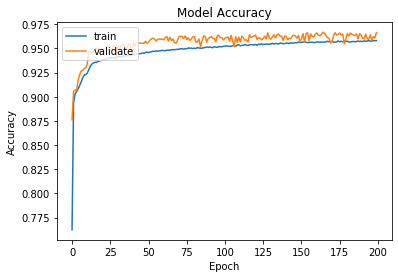

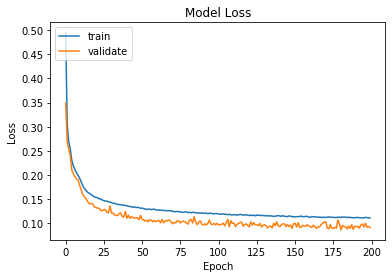

In [50]:
# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.draw()
plt.show()
plt.pause(1)    

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.draw()
plt.show()
plt.pause(1)

In [51]:
y_pred = model.predict(X_test)

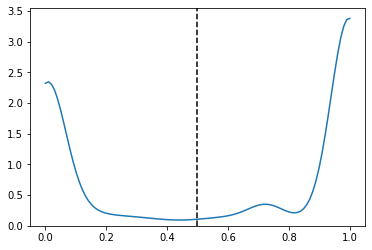

In [52]:
sns.kdeplot(y_pred.flatten(),cut=0);
thresh = filters.threshold_otsu(y_pred)
plt.axvline(thresh, color='k', ls='--');
plt.draw()
plt.show()


In [53]:
print('Otsu Threshold:', thresh)
print('Precision Score:', precision_score(y_test, y_pred>thresh))
print('Recall Score:', recall_score(y_test, y_pred > thresh))
print('F1-Score:', f1_score(y_test, y_pred > thresh))

Otsu Threshold: 0.49881002
Precision Score: 0.9803745149862227
Recall Score: 0.9637901487091602
F1-Score: 0.9720115967885816


## visualize model

In [21]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

from ann_visualizer.visualize import ann_viz;
import numpy


ann_viz(model, title="Artificial Neural network - Model Visualization")

# Do inference

In [54]:
# load model
from keras.models import load_model

path = '../../TreeTect/data/bfalg_models/bfalg_batchSize_200_Epoch-00200-Val_acc-0.95808_weights.hdf5'
model = load_model(path)

In [55]:
from skimage import exposure
from skimage.filters import threshold_otsu, threshold_local
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd

from gbdxtools import Interface
gbdx = Interface()

In [56]:
def rgb_from_raster(data, brightness):
    
    bands, x, y = data.shape
    
    # create plottable image
    brightness = 0.3
    blue = data[1].astype(np.float32)
    green = data[2].astype(np.float32)
    red = data[4].astype(np.float32)
    rgb = np.zeros((x,y,3))
    rgb[...,0] = red
    rgb[...,1] = green
    rgb[...,2] = blue
    rgb = rgb - np.min(rgb)
    rgb = rgb / np.maximum(np.max(rgb), 1) + brightness
    
    if rgb.mean() > 1:
        rgb[rgb > 255] = 255
    else: 
        rgb[rgb > 1] = 1
    
    return rgb

# Create function that reshapes numpy arrays
def reshape(index):
    index = np.reshape(index,[1,index.shape[0],index.shape[1]])
    return(index)

## Get data from GBDX

In [57]:
# get setu babakan data and write to geotiff

# rawa indah = 106.885, -6.36, 106.89, -6.355 , 1030010085B5FC00
# rawa babon = 106.884, -6.341, 106.888, -6.335, 10400100503B3A00

# manila test = 121.004, 14.531, 121.007, 14.535 , 10300100A4711D00

# Shenzen = 114.07, 22.533, 114.074, 22.536 , 10300100A3350C00

from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '10300100A4711D00')
bbox = env.inputs.get('bbox', '121.006, 14.535, 121.009, 14.537 ')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")), pansharpen = True)


import datetime



image_id = catalog_id

# Get timestamp
time_image = image.metadata["image"]["acquisitionDate"] 

# convert timestamp to datetime timestamp format
time_image = datetime.datetime.strptime(time_image, "%Y-%m-%dT%H:%M:%S.%fZ")
    
time_image_str = time_image.strftime('%Y-%m-%d_%H:%M')



KeyboardInterrupt: 

In [ ]:
name = 'Manila_roofs'

In [37]:
path = "../../TreeTect/data/rasters_waterbodies_osm/{}_{}_{}.tif".format(name,time_image_str,image_id)

path

tif = image.geotiff(
    path = path
                 )

In [38]:
path

'../../TreeTect/data/rasters_waterbodies_osm/Manila_roofs_2020-02-29_02:32_10300100A4711D00.tif'

## Use raster file

In [72]:
# find files in shapefile folder

name = 'Shenzen'
save_classification = True

raster_files_path = '../../TreeTect/data/rasters_waterbodies_osm/Shenzen/{}*.tif'.format(name)
raster_files = glob.glob(raster_files_path)
file_path = raster_files[0]

print(len(raster_files))
print('-------------------------------------')
pprint(raster_files[0:5])
print('-------------------------------------')
print(file_path)


1
-------------------------------------
['../../TreeTect/data/rasters_waterbodies_osm/Shenzen/Shenzen_001_2020-02-17_03:11_10300100A3350C00.tif']
-------------------------------------
../../TreeTect/data/rasters_waterbodies_osm/Shenzen/Shenzen_001_2020-02-17_03:11_10300100A3350C00.tif


In [73]:
if len(raster_files) == 1:
    sample_size = 1
else:
    sample_size = 3

../../TreeTect/data/rasters_waterbodies_osm/Shenzen/Shenzen_001_2020-02-17_03:11_10300100A3350C00.tif
585208/585208 [==============================] - 20s 34us/step


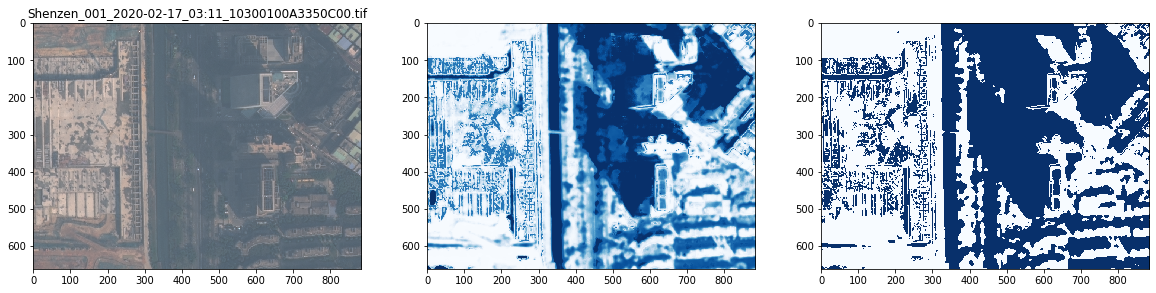

saved as:  ../../TreeTect/data/raster_classifications/classification_Shenzen_001_2020-02-17_03:11_10300100A3350C00.tif


In [74]:

for file_path in np.array(pd.DataFrame(raster_files).sample(sample_size)).flatten(): 
    
    print(file_path)
    filename = file_path.split('/')[-1]

    import rasterio

    data = rasterio.open(file_path).read()
    dataset = rasterio.open(file_path)

    transform = dataset.meta['transform']
    width = dataset.meta['width']
    height = dataset.meta['height']

    # Split image data into band layers
    coastal = data[0] 
    blue    = data[1]
    green   = data[2]
    yellow  = data[3]
    red     = data[4] 
    red_edge = data[5] 
    nir1 = data[6]
    nir2 = data[7]
    
    # get info from filenames
    stringlist = file_path.split('/')[-1].split('_')
    image_id = stringlist[-1].split('.')[0]

    # get metadata from GBDX
    record = gbdx.catalog.get(image_id)

    # add metadata to data 
    i = 8
    for property_name in property_names:

            try: 
                property_record = record['properties'][property_name]  

                property_array = np.empty([1,data.shape[1],data.shape[2]])
                property_array.fill(property_record)

                data = np.vstack([data,property_array])
            except: 
                print('failed ', property_name, image_id)
                property_array = np.empty([1,data.shape[1],data.shape[2]])
                data = np.vstack([data,property_array])

            i = i + 1


    # Calculate indices
    # Make sure ndvi and ndwi are stackable with band data by making them 3-dimensional (1,x,y)
    ndvi = reshape((nir1 - red)/(nir1 + red))
    ndwi = reshape((green - nir1) / (green + nir1))
    wwi = reshape((coastal - nir2) / (coastal + nir2 + 10e-5))

    # Stack arrays in sequence vertically (row wise)
    image_array = np.vstack([data,ndvi,ndwi, wwi])
    # select all variables of interest
    image_array = image_array[variable_selection,:,:]

    ### Reshape the data prior to feeding it through the model.
    # Flatten the two-dimensional imagery (i.e., Reshape)
    d2, h2, w2 = image_array.shape
    data_pred = np.reshape(image_array,(d2,h2*w2)).T

    # Convert data type to 32-bit float, and normalize between 0 and 1
    data_pred.astype(np.float32)
    data_pred = (data_pred - min_data) / (max_data - min_data)

    # Next, conduct model prediction on each spectral column
    labels_pred = model.predict(data_pred, verbose = 1, workers = 4)
    labels_pred = np.reshape(labels_pred,(h2,w2))

    ### Calculate threshold for classification  
    thresh = filters.threshold_otsu(labels_pred)

    ### Plot the input image alongside its corresponding predictions.
    plt.figure(figsize=(20,20))
    plt.subplot(131);plt.imshow(rgb_from_raster(data, 0.0)); plt.title(filename)
    plt.subplot(132);plt.imshow(labels_pred, cmap = 'Blues');
    plt.subplot(133);plt.imshow(labels_pred > 0.4, cmap = 'Blues');
    plt.draw()
    plt.show()
    
    ### save classifications to raster
    labels_pred = labels_pred.astype(float)
    
    array_classification = labels_pred > thresh
    array_classification = array_classification.astype(float)
    
    classification_filename = '../../TreeTect/data/raster_classifications/classification_' + filename
    
    
    if save_classification:
        with rasterio.open(
            classification_filename,
            'w',
            driver='GTiff',
            height=labels_pred.shape[0],
            width=labels_pred.shape[1],
            count=1,
            dtype=labels_pred.dtype,
            crs='+proj=latlong',
            transform=transform,
        ) as dst:
            dst.write(labels_pred, 1)


        print('saved as: ', classification_filename)


In [28]:
with rasterio.open(
    classification_filename,
    'w',
    driver='GTiff',
    height=labels_pred.shape[0],
    width=labels_pred.shape[1],
    count=1,
    dtype=labels_pred.dtype,
    crs='+proj=latlong',
    transform=transform,
) as dst:
    dst.write(labels_pred, 1)


print('saved as: ', classification_filename)

saved as:  ../../TreeTect/data/raster_classifications/classification_Manila_001_2020-02-29_02:32_10300100A4711D00.tif


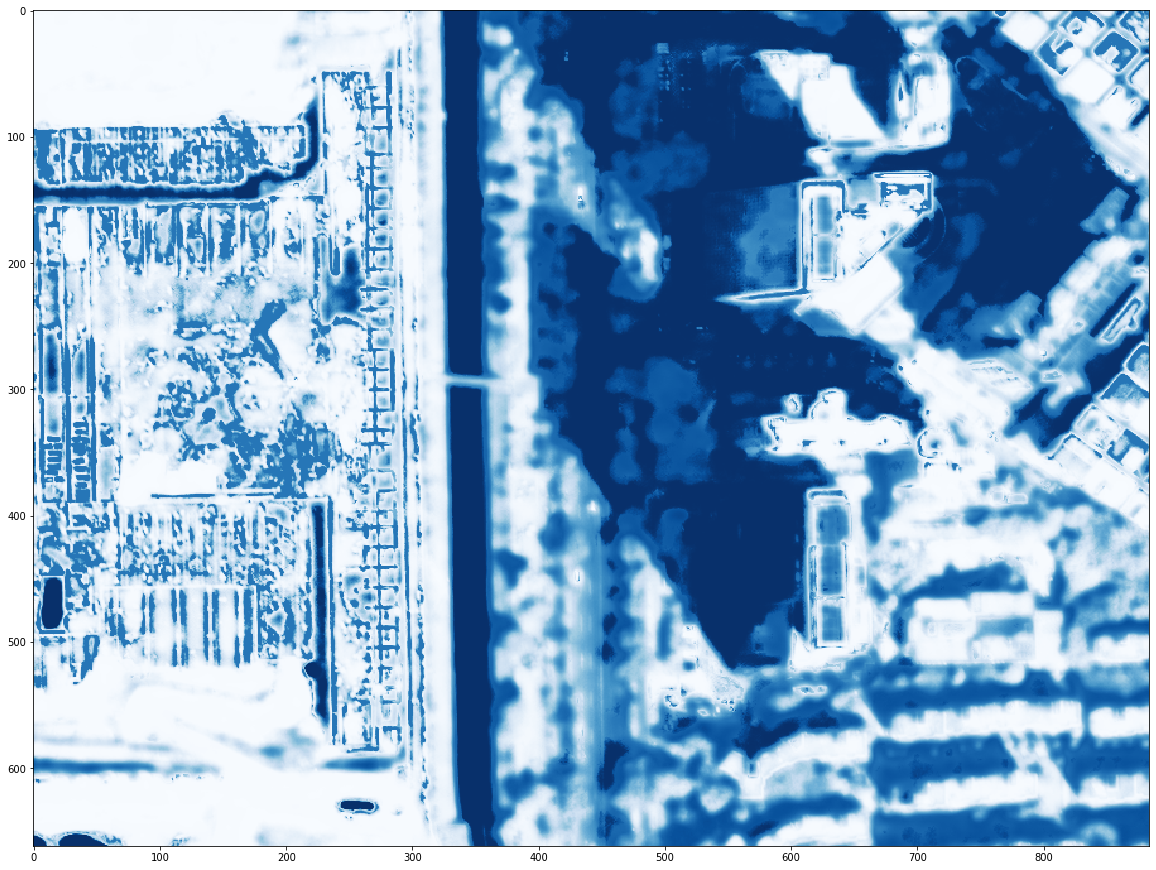

In [75]:
plt.figure(figsize = (20,20))
plt.imshow(labels_pred, cmap = 'Blues')